In [ ]:
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

from tensorflow.keras import layers
import matplotlib.pyplot as plt
import matplotlib.pylab as plb
import numpy as np
import pandas as pd
from keras.layers import Input, Dense, Activation, Flatten, Conv2D, Lambda, MaxPooling2D, Dropout
from keras import models
from keras import layers
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import VGG16
from keras_preprocessing.image import ImageDataGenerator
from scipy import pi




2.3.0


In [ ]:
trainDF = pd.read_csv("/home/jupyter/Thesis/train.txt", sep=" ", header=None)
trainDF.columns = ['Images', 'SteeringAngle'] 
trainDF['SteeringAngle'] = trainDF['SteeringAngle'] * (pi / 180)

testDF = pd.read_csv('/home/jupyter/Thesis/test.txt', sep=" ", header=None)
testDF.columns = ['Images', 'SteeringAngle'] 
testDF['SteeringAngle'] = testDF['SteeringAngle'] * (pi / 180)

datagen = ImageDataGenerator(
            rescale=1./255,            
            validation_split=0.25)

trainData = trainDF.shape[0] * 0.75
valData = trainDF.shape[0] * 0.25
# print(trainData, valData)

test_datagen = ImageDataGenerator(rescale=1./255)

BatchSize = 98

train_generator=datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Thesis/train/",
x_col="Images",
y_col="SteeringAngle",
subset="training",
batch_size=BatchSize,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(100,200))

validation_generator = datagen.flow_from_dataframe(
dataframe=trainDF,
directory="/home/jupyter/Thesis/train/",
x_col="Images",
y_col="SteeringAngle",
subset="validation",
batch_size=BatchSize,
seed=42,
shuffle=False,
class_mode="raw",
target_size=(100,200))


Found 27342 validated image filenames.
Found 9114 validated image filenames.


In [ ]:
from keras.applications import ResNet50V2

def ResNet50_FE(width, height, depth):

    conv_base = ResNet50V2(weights='imagenet', include_top=False, input_shape=(height, width, depth))

    model = models.Sequential()
    model.add(conv_base)
    conv_base.trainable = False
    model.add(layers.Flatten())

    model.add(Dense(1164, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(100, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(50, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(10, activation='relu'))    
    model.add(Dense(1, activation='linear'))

    return model


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50v2 (Model)           (None, 4, 7, 2048)        23564800  
_________________________________________________________________
flatten_2 (Flatten)          (None, 57344)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1164)              66749580  
_________________________________________________________________
dropout_4 (Dropout)          (None, 1164)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 100)               116500    
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 50)               

/opt/conda/lib/python3.7/site-packages/keras/engine/saving.py:165: UserWarning: TensorFlow optimizers do not make it possible to access optimizer attributes or optimizer state after instantiation. As a result, we cannot save the optimizer as part of the model save file.You will have to compile your model again after loading it. Prefer using a Keras optimizer instead (see keras.io/optimizers).
  'TensorFlow optimizers do not '


279/279 [==============================] - 115s 411ms/step - loss: 0.2290 - val_loss: 0.1341

Epoch 00002: saving model to /home/jupyter/Thesis/ResNet50/FE/ResNet50_FE_weights.02-0.13.h5
Epoch 3/10
279/279 [==============================] - 115s 413ms/step - loss: 0.2065 - val_loss: 0.1299

Epoch 00003: saving model to /home/jupyter/Thesis/ResNet50/FE/ResNet50_FE_weights.03-0.13.h5
Epoch 4/10
279/279 [==============================] - 116s 416ms/step - loss: 0.1876 - val_loss: 0.1113

Epoch 00004: saving model to /home/jupyter/Thesis/ResNet50/FE/ResNet50_FE_weights.04-0.11.h5
Epoch 5/10
279/279 [==============================] - 116s 414ms/step - loss: 0.1724 - val_loss: 0.1133

Epoch 00005: saving model to /home/jupyter/Thesis/ResNet50/FE/ResNet50_FE_weights.05-0.11.h5
Epoch 6/10
279/279 [==============================] - 115s 414ms/step - loss: 0.1585 - val_loss: 0.0866

Epoch 00006: saving model to /home/jupyter/Thesis/ResNet50/FE/ResNet50_FE_weights.06-0.09.h5
Epoch 7/10
279/279 [=

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


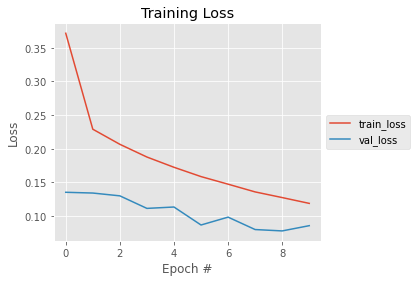

In [ ]:
from keras.callbacks import ModelCheckpoint

NUM_EPOCHS = 10

model = ResNet50_FE(width=200, height=100, depth=3)
print (model.summary())

model.compile(optimizer=tf.keras.optimizers.Adadelta(lr=1e-2), loss="mse")

filepath = "/home/jupyter/Thesis/ResNet50/FE/ResNet50_FE_weights.{epoch:02d}-{val_loss:.2f}.h5"

checkpoint = ModelCheckpoint(filepath, verbose=1)

history = model.fit(
                train_generator,
                steps_per_epoch=round(trainData/BatchSize),
                epochs=NUM_EPOCHS,
                validation_data=validation_generator,
                validation_steps=round(valData/BatchSize),
                callbacks=[checkpoint])

plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, NUM_EPOCHS), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, NUM_EPOCHS), history.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
# https://stackoverflow.com/questions/4700614/how-to-put-the-legend-out-of-the-plot
ax = plt.subplot(111)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [ ]:
from keras.models import load_model
from sklearn.metrics import mean_absolute_error

test_generator=test_datagen.flow_from_dataframe(
dataframe=testDF,
directory="/home/jupyter/Thesis/test/",
x_col="Images",
# y_col="SteeringAngle",
y_col=None,    
batch_size=100,
seed=42,
shuffle=False,
class_mode=None,
target_size=(100,200))

filepath = "/home/jupyter/Thesis/ResNet50/FE/ResNet50_FE_weights.10-0.09.h5"

model.load_weights(filepath)


predictions = model.predict(test_generator)

MAE = mean_absolute_error(testDF.iloc[:, -1], predictions)
print(MAE)

Found 8950 validated image filenames.
0.19949488216376757
